In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# plt.style.use('ggplot')
# import matplotlib2tikz

idx = pd.IndexSlice
sys.path.append(str(Path.cwd()))

from plotting_constants import colors, min_cost_acceleration_factor

In [2]:
root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep"

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [4]:
mode = "static"

assert mode in ["static", "both"]

def get_data(mode, op):

    index_col = [0,1,2]
    header = [0,1,2,3,4,5,6,7,8]

    df = pd.read_csv(
        root / "joint_data" / 
        "nodal_capacities.csv", 
        index_col=index_col,
        header=header,
        )
    df = df.loc[:,idx[:,:,:,:,:,mode,op]].iloc[:,2:]

    df = df.groupby(level=[0,2]).sum()

    df.columns = df.columns.droplevel([0,1,2,3,5,7,8])

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier

    df = df.loc["links injection geothermal heat"].loc[idx[:, op]].mul(1e-3)

    df.index = (df.index.to_numpy().astype(int) + min_cost_acceleration_factor).astype(int)

    return df


In [5]:
cost_data = pd.read_csv(
    Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data" / "costs.csv",
    index_col=[0,1,2],
    header=[4,5,6,7,8],
    ).sum()

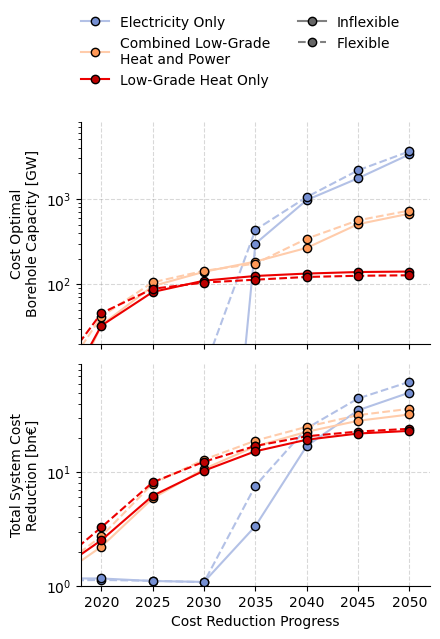

In [10]:
from matplotlib.patches import Patch

elec_static = get_data("elec", "static")
chp_static = get_data("chp", "static")
dh_static = get_data("dh", "static")

elec_flex = get_data("elec", "flex")
chp_flex = get_data("chp", "flex")
dh_flex = get_data("dh", "flex")


# fig, axs = plt.subplots(3, 1, figsize=(7, 7))
fig, axs = plt.subplots(2, 1, figsize=(4.5, 6.5))

# elec_static.plot.(ax=ax, stacked=True, width=0.8, edgecolor='black', linewidth=0.5)

labels = {
    # "elec static": "Electricity Only, Inflexible Operation",
    "elec static": "Electricity Only",
    # "elec flex": "Electricity Only, Operation with Storage",
    # "chp static": "Combined Heat and Power, Inflexible Operation",
    "chp static": "Combined Low-Grade Heat and Power",
    # "chp flex": "Combined Heat and Power, Operation with Storage",
    # "dh static": "District Heating, Inflexible Operation",
    "dh static": "Low-Grade Heat Only",
    # "dh flex": "District Heating, Operation with Storage",
}

line_kwargs = {
    "marker": 'o',
    "markersize": 6,
    "linewidth": 1.5,
    "markeredgewidth": 1,
    "markeredgecolor": "k",
}

def plot_flex_capacity_to_ax(ax):

    ax.plot(
        elec_static.index.astype(int),#[:-1],
        elec_static.values,#[:-1],
        color=colors["elec"],
        # label=labels["elec static"],
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        **line_kwargs
        )

    ax.plot(
        elec_flex.index.astype(int),#[:-1],
        elec_flex.values,#[:-1],
        color=colors["elec"],
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        linestyle="--",
        **line_kwargs
        )

    ax.plot(
        chp_static.index.astype(int),
        chp_static.values,
        color=colors["chp"],
        # label=labels["chp static"],
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
        **line_kwargs)

    ax.plot(
        chp_flex.index.astype(int),
        chp_flex.values,
        color=colors["chp"],
        # label=labels["chp static"],
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
        linestyle="--",
        **line_kwargs)

    ax.plot(
        dh_static.index.astype(int),
        dh_static.values, color=colors["dh"],
        # label=labels["dh static"],
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
        **line_kwargs)

    ax.plot(
        dh_flex.index.astype(int),
        dh_flex.values, color=colors["dh"],
        # label=labels["dh static"],
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
        linestyle="--",
        **line_kwargs)

    ax.set_ylabel("Cost Optimal\nBorehole Capacity [GW]")
    # ax.set_ylim(18, 1.3e4)


plot_flex_capacity_to_ax(axs[0])


def plot_flex_costs_to_ax(ax):

    max_cost = cost_data.max()

    for mode in ["elec", "chp", "dh"]:

        color = colors[mode]

        plot_data = cost_data.loc[idx[:,mode,"flex"]]

        plot_data.index = plot_data.index.get_level_values(0).astype(int).to_numpy() + min_cost_acceleration_factor


        plot_data.iloc[2:].sub(max_cost).abs().mul(1e-9).add(1.).plot(
            ax=ax,
            color=color,
            marker="o",
            markersize=line_kwargs["markersize"],
            linewidth=line_kwargs["linewidth"],
            markeredgewidth=1,
            markeredgecolor="k",
            markerfacecolor=adjust_lightness(color, 0.8),
            linestyle="--",
        )

        plot_data = cost_data.loc[idx[:,mode,"static"]]
        plot_data.index = plot_data.index.get_level_values(0).astype(int).to_numpy() + min_cost_acceleration_factor

        plot_data.iloc[2:].sub(max_cost).abs().mul(1e-9).add(1.).plot(
            ax=ax,
            color=color,
            marker="o",
            markersize=line_kwargs["markersize"],
            linewidth=line_kwargs["linewidth"],
            markeredgewidth=1,
            markeredgecolor="k",
            markerfacecolor=adjust_lightness(color, 0.8),
        )
    ax.set_yscale("log")
    ax.set_ylabel("Total System Cost\nReduction [bn€]")
    # ax.set_ylim(1.9, 250)


plot_flex_costs_to_ax(axs[1])

for ax in axs:

    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yscale("log")

handles = []
labels = []


labels.append("Electricity Only")
handles.append(
    Line2D(
        [0], [0], color=colors["elec"],
        marker="o",
        markersize=line_kwargs["markersize"],
        linewidth=line_kwargs["linewidth"],
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        ))
    
labels.append("Combined Low-Grade\nHeat and Power")
handles.append(
    Line2D(
        [0], [0], color=colors["chp"],
        marker="o",
        markersize=line_kwargs["markersize"],
        linewidth=line_kwargs["linewidth"],
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
    ))

labels.append("Low-Grade Heat Only")
handles.append(
    Line2D(
        [0], [0], color=colors["dh"],
        marker="o",
        markersize=line_kwargs["markersize"],
        linewidth=line_kwargs["linewidth"],
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
    ))

# handles.append(Patch(facecolor="white", edgecolor="white"))
# labels.append("")
    
labels.append("Inflexible")
handles.append(
    Line2D(
        [0], [0], color="grey",
        marker="o",
        markersize=line_kwargs["markersize"],
        linewidth=line_kwargs["linewidth"],
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness("grey", 0.8),
        ))
labels.append("Flexible")

handles.append(
    Line2D(
        [0], [0], color="grey",
        marker="o",
        markersize=line_kwargs["markersize"],
        linewidth=line_kwargs["linewidth"],
        linestyle="--",
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness("grey", 0.8),
        ))

    # axs[0].legend(handles=handles, labels=labels, loc="upper left") 
axs[0].legend(
    handles,
    labels,
    bbox_to_anchor=(0.95, 1.1),
    loc='lower right',
    frameon=False,
    ncol=2,
    fancybox=False,
)

axs[0].set_xticklabels([])
axs[0].set_xlabel("")
axs[1].set_xlabel("Cost Reduction Progress")

axs[0].set_xlim(2018, 2052)
axs[1].set_xlim(2018, 2052)
axs[0].set_ylim(20, 8e3)
axs[1].set_ylim(1, 9e1)

plt.tight_layout()
plt.savefig("nonflex_flex_operation.pdf")

plt.show()